# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

In [5]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt 

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [27]:
training_path_list = []  # Gleiche Liste aus Aufgabe 2
test_path_list = []  # Gleiche Liste aus Aufgabe 2
validation_path_list = []  # ["./pfad/zu/bildZ.png","./pfad/zu/bildY.png",...]

training_path_list = [f'Bilder/Flur/Flur{i + 1}.jpg' for i in range(20)] + \
                     [f'Bilder/Labor/Labor{i + 1}.jpg' for i in range(20)] + \
                     [f'Bilder/Professorenbuero/Professorenbuero{i + 1}.jpg' for i in range(20)] + \
                     [f'Bilder/Teekueche/Teekueche{i + 1}.jpg' for i in range(20)]

test_path_list = [f'Bilder/Flur/Flur{i + 21}.jpg' for i in range(5)] + \
                 [f'Bilder/Labor/Labor{i + 21}.jpg' for i in range(5)] + \
                 [f'Bilder/Professorenbuero/Professorenbuero{i + 21}.jpg' for i in range(5)] + \
                 [f'Bilder/Teekueche/Teekueche{i + 21}.jpg' for i in range(5)]

idx_train = [0, 10, 20, 30, 40, 50, 60, 70]
idx_test = [0, 1, 5, 6, 10, 11, 15, 16]

validation_path_list = [training_path_list[i] for i in idx_train] + \
                       [test_path_list[i] for i in idx_test]

# Labels
# idx: 0=FLur, 1=Labor, 2=Professorenbureau, 3=Teeküche

y_train = [0 for i in range(20)] + \
          [1 for i in range(20)] + \
          [2 for i in range(20)] + \
          [3 for i in range(20)]

y_test = [0 for i in range(5)] + \
         [1 for i in range(5)] + \
         [2 for i in range(5)] + \
         [3 for i in range(5)]

y_val = [
    0, 0,
    1, 1,
    2, 2,
    3, 3,
    0, 0,
    1, 1,
    2, 2,
    3, 3,
]


## Teilaufgabe b): CNN definieren und implementieren

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden. 

Input sind: 
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!) 
- Transformation der Bilder


In [13]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list
        
        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels
        
        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        image = read_image(img_path)
        
        # Label laden
        label = self.img_labels[idx]
        
        # Transformieren
        if self.transform:
            image = self.transform(image)
            
        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [47]:
from torchmetrics import Accuracy
def accuracy_score(output, labels):
    output = torch.from_numpy(output)
    labels = torch.from_numpy(labels)
    acc = Accuracy(task="multiclass", num_classes=4)
    r = acc(output, labels)
    return r

# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)
        
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))
    
    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

Running on  cpu

Started Training
Epoch 1 from 100
	Train Loss	 1.4183415
	Train Acc.	 0.225
	Val Loss	 1.2451375
	Val Acc.	 0.5
Epoch 2 from 100
	Train Loss	 1.070863
	Train Acc.	 0.575
	Val Loss	 1.0074345
	Val Acc.	 0.5625
Epoch 3 from 100
	Train Loss	 0.64315426
	Train Acc.	 0.7875
	Val Loss	 0.99855417
	Val Acc.	 0.625
Epoch 4 from 100
	Train Loss	 0.41612974
	Train Acc.	 0.8375
	Val Loss	 1.4108666
	Val Acc.	 0.5
Epoch 5 from 100
	Train Loss	 0.21760003
	Train Acc.	 0.9375
	Val Loss	 0.84444374
	Val Acc.	 0.6875
Epoch 6 from 100
	Train Loss	 0.16266409
	Train Acc.	 0.95
	Val Loss	 1.1489033
	Val Acc.	 0.625
Epoch 7 from 100
	Train Loss	 0.098078415
	Train Acc.	 0.975
	Val Loss	 0.86796653
	Val Acc.	 0.75
Epoch 8 from 100
	Train Loss	 0.029642751
	Train Acc.	 1.0
	Val Loss	 1.6029187
	Val Acc.	 0.625
Epoch 9 from 100
	Train Loss	 0.03389635
	Train Acc.	 1.0
	Val Loss	 1.155019
	Val Acc.	 0.625
Epoch 10 from 100
	Train Loss	 0.0072872452
	Train Acc.	 1.0
	Val Loss	 1.2218157
	Val A

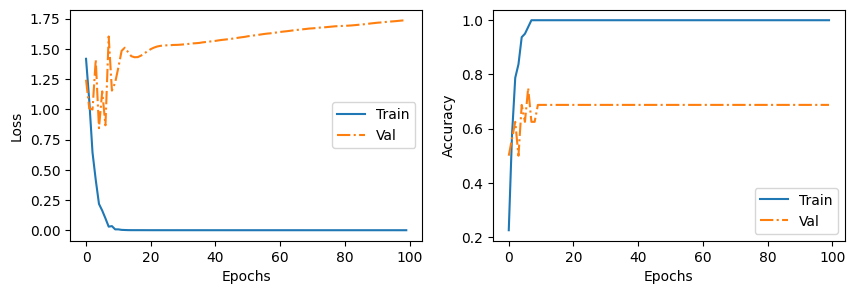

In [50]:
# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001

# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ", device)

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")
    
    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()

## Teilaufgabe d): Augmentierung

## Teilaufgabe e): Early Stopping